# 5. Signature analysis

Next, we aim to analyze whether molecules localized extracellularly form consistent spatial patterns. For this, we will perform factor analysis. We will also try to link this factor with previously identified cell types

# Further expand on this

## Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import spatialdata as sd

import troutpy

/home/sergio/.local/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/sergio/.local/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/sergio/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Read SpatialData object

In [2]:
xenium_path_cropped = "/media/sergio/Meninges/troutpy/xenium_msbrain/mousebrain_prime_crop_communication.zarr"
output_path = "/media/sergio/Meninges/troutpy"
sdata = sd.read_zarr(xenium_path_cropped)

In [3]:
transcripts = sdata["transcripts"].compute()  # type: ignore
transcripts["extracellular"] = ~transcripts["extracellular"]
sdata["transcripts"] = sd.models.PointsModel.parse(transcripts)

We first need to aggregate extracellular transcripts. For this, in this case, we will employ the binning approach, defining equally distributed squares covering the entire tissue

In [4]:
troutpy.pp.filter_xrna(sdata, min_logfoldratio_over_noise=4)

In [5]:
# use troutpy's implementation, not local
troutpy.pp.aggregate_extracellular_transcripts(
    sdata, layer="transcripts", gene_key="feature_name", method="fragments", square_size=10, radius=4, copy=False, key_added=None
)

In [25]:
sdata["segmentation_free_table"]

AnnData object with n_obs × n_vars = 6848 × 13073
    obs: 'instance_id', 'region'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [ ]:
# use troutpy's implementation, not local
troutpy.pp.aggregate_extracellular_transcripts(
    sdata, layer="transcripts", gene_key="gene", method="radius", square_size=50, radius=4, copy=False, key_added=None
)

Computing signatures: 100%|██████████| 121125/121125 [00:00<00:00, 304799.22it/s]


In [34]:
sdata["segmentation_free_table"].var.index

Index(['Aldoa', 'App', 'Atp2a2', 'Camk2a', 'Camk2b', 'Ckb', 'Cyfip2', 'Dnm1',
       'Eno2', 'Gabbr1', 'Gnao1', 'Gria2', 'Map1b', 'Map2', 'Ptprn2', 'Rab3a',
       'Rtn3', 'Slc17a7', 'Snap25', 'Sncb', 'Sptan1', 'Stxbp1', 'Syn1', 'Syp',
       'Uchl1', 'Ywhag', 'Ywhaz'],
      dtype='object')

In [35]:
sdata["segmentation_free_table"].obs["total_counts"] = np.sum(sdata["segmentation_free_table"].X, axis=1)

(array([4.500e+01, 0.000e+00, 1.010e+02, 0.000e+00, 1.610e+02, 0.000e+00,
        0.000e+00, 3.160e+02, 0.000e+00, 5.020e+02, 0.000e+00, 5.970e+02,
        0.000e+00, 0.000e+00, 7.410e+02, 0.000e+00, 9.090e+02, 0.000e+00,
        0.000e+00, 1.015e+03, 0.000e+00, 1.182e+03, 0.000e+00, 1.495e+03,
        0.000e+00, 0.000e+00, 1.550e+03, 0.000e+00, 1.713e+03, 0.000e+00,
        2.069e+03, 0.000e+00, 0.000e+00, 2.375e+03, 0.000e+00, 2.620e+03,
        0.000e+00, 0.000e+00, 2.911e+03, 0.000e+00, 3.072e+03, 0.000e+00,
        3.311e+03, 0.000e+00, 0.000e+00, 3.531e+03, 0.000e+00, 3.530e+03,
        0.000e+00, 0.000e+00, 3.820e+03, 0.000e+00, 3.844e+03, 0.000e+00,
        3.901e+03, 0.000e+00, 0.000e+00, 4.037e+03, 0.000e+00, 4.057e+03,
        0.000e+00, 4.123e+03, 0.000e+00, 0.000e+00, 4.000e+03, 0.000e+00,
        4.002e+03, 0.000e+00, 0.000e+00, 3.929e+03, 0.000e+00, 3.740e+03,
        0.000e+00, 3.700e+03, 0.000e+00, 0.000e+00, 3.489e+03, 0.000e+00,
        3.446e+03, 0.000e+00, 3.132e+0

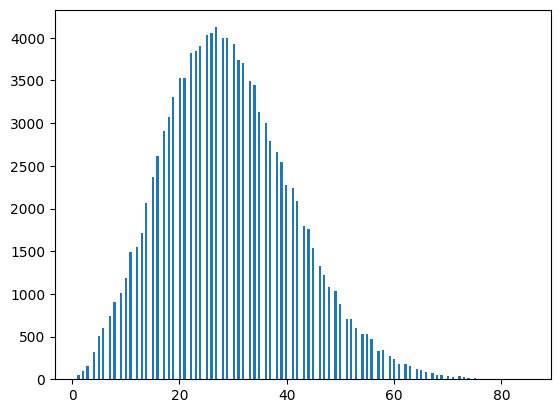

In [36]:
plt.hist(sdata["segmentation_free_table"].obs["total_counts"], 200)

In [ ]:
troutpy.pp.aggregate_extracellular_transcripts(sdata, square_size=10)

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


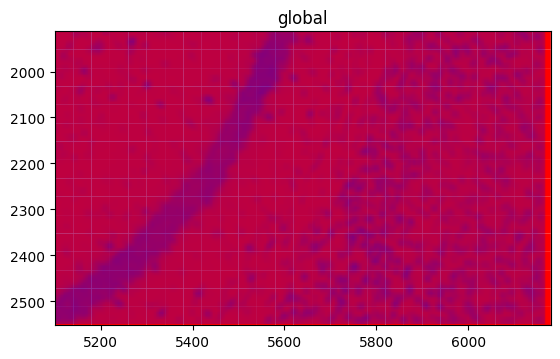

In [ ]:
ax = plt.gca()
sdata.pl.render_shapes("grid_squares", na_color="red", alpha=0.5).pl.show(ax=ax)
sdata.pl.render_points("transcripts", na_color="blue", alpha=0.5).pl.show(ax=ax)

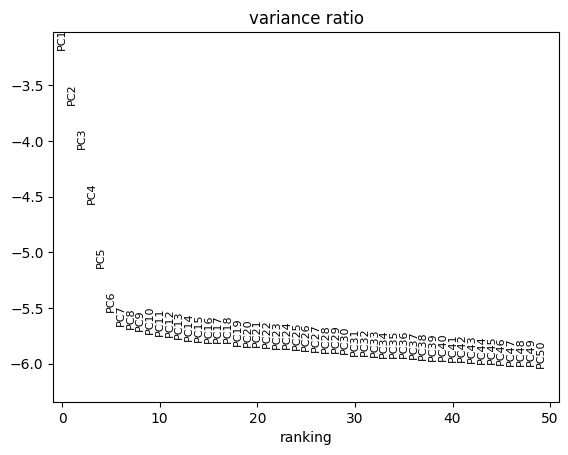

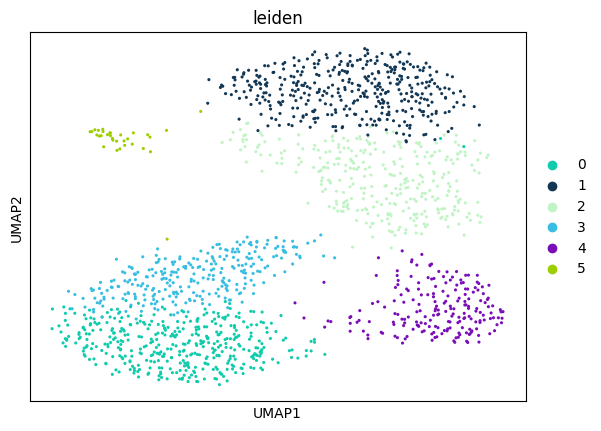

In [ ]:
adata = sdata.tables["segmentation_free_table"]
adata.raw = adata
sc.pp.filter_cells(adata, min_genes=4)
sc.pp.filter_cells(adata, min_counts=7)
sc.pp.filter_genes(adata, min_cells=20)
adata.layers["raw"] = adata.X.copy()
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
# pca
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
# neighbors
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden")
cold_palette = troutpy.pl.get_palette("cold_colors", n_colors=30)
sc.pl.umap(adata, color="leiden", palette=cold_palette, s=20)

[<Axes: title={'center': 'cell_type'}, xlabel='spatial1', ylabel='spatial2'>]

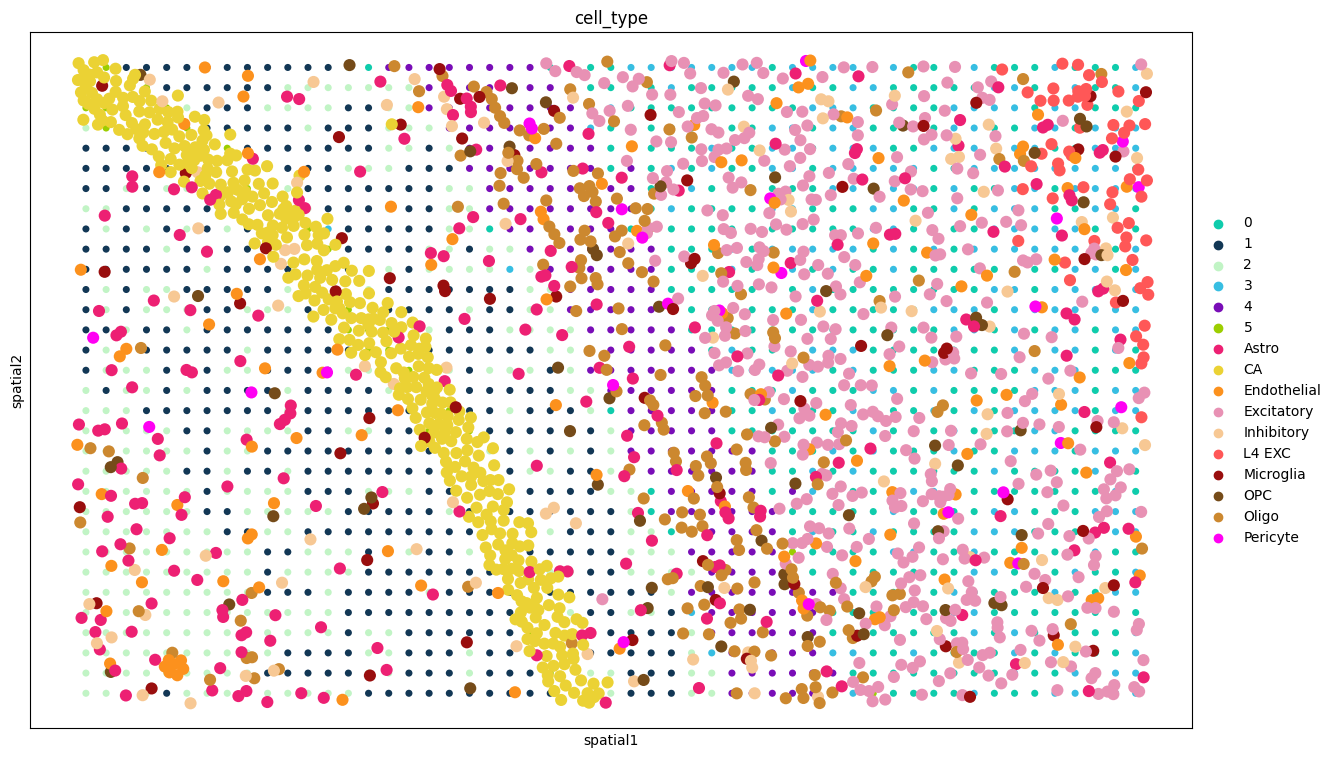

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
cold_palette = troutpy.pl.get_palette("cold_colors", n_colors=30)
warm_palette = troutpy.pl.get_palette("calid_colors", n_colors=30)
sc.pl.spatial(adata, color="leiden", spot_size=7, show=False, ax=ax, marker="s", palette=cold_palette)
sc.pl.spatial(
    sdata["table"],
    color="cell_type",
    spot_size=12,
    show=False,
    ax=ax,
    marker="*",
    outline_width=(0.8, 0.05),
    outline_color="black",
    palette=warm_palette,
)

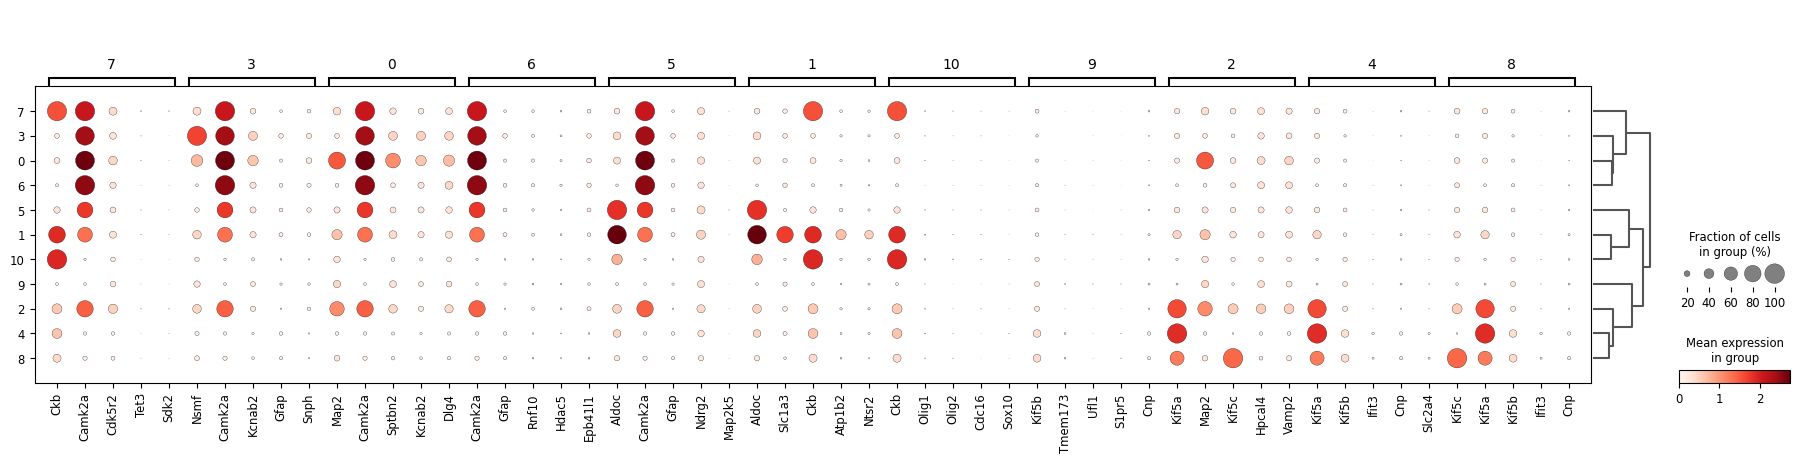

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="leiden")
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", n_genes=5)

# Latent factor analysis

After we have grouped exRNA based on spatial localization, we can now identify the latent factors that might be driving exRNA. For this, we employ the function `troutpy.tl.latent_factor`, selecting the method desired from the available ones. Currently Non-negative matrix factorization (`NMF`) and LatentDirichletAllocation (`LDA`)

In [ ]:
troutpy.tl.latent_factor(sdata, method="NMF", layer="segmentation_free_table", n_components=10)

We next apply the latent factors, computed using extracellular space, to each of the cells, located in `sdata['table]`,in order to identify if any of the extracellular factors correspond to specific cell types 

In [ ]:
troutpy.tl.apply_exrna_factors_to_cells(sdata, extracellular_layer="segmentation_free_table", cellular_layer="table")

# Plotting output

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns
from anndata import AnnData
from spatialdata import SpatialData  # Assuming SpatialData is from scverse

from troutpy.pl.colors import get_colormap


def rank_factor_genes_loadings_matrixplot(
    sdata: SpatialData,
    layer: str,
    n_genes: int = 5,
    cmap: str = "Pinks",
    vmin: float | None = None,
    vmax: float | None = None,
    show: bool = True,
    save: str | None = None,
):
    """
    Plot ranking of genes using a matrixplot based on factor loadings.

    Parameters
    ----------
    sdata : spatialdata.SpatialData
        The spatial data object containing gene expression information.
    layer : str
        The layer in `sdata` that contains the AnnData object.
    n_genes : int
        Number of top genes to plot per factor, by default 20.
    cmap : str
        Colormap for visualization, by default "bwr".
    vmin, vmax : float
        Color scaling limits.
    show : bool
        Whether to display the plot, by default True.
    save : str
        Path to save the figure, by default None.
    """
    adata: AnnData = sdata[layer]
    gene_loadings = adata.varm["gene_loadings"]  # Shape: genes x factors
    factor_names = [f"Factor {i + 1}" for i in range(gene_loadings.shape[1])]

    # Identify top genes per factor
    top_genes = {}
    for i, factor in enumerate(factor_names):
        top_indices = np.argsort(-np.abs(gene_loadings[:, i]))[:n_genes]
        top_genes[factor] = adata.var_names[top_indices].tolist()

    # Convert to heatmap-friendly format
    gene_list = [gene for gl in top_genes.values() for gene in gl]  # Unique genes across all factors
    factor_matrix = np.array([gene_loadings[adata.var_names.get_indexer(gene_list), i] for i in range(gene_loadings.shape[1])]).T
    print(top_genes)
    # Ensure colormap is valid
    if cmap not in plt.colormaps():
        try:
            cmap = get_colormap(cmap)
        except KeyError:
            pass

    # Plot heatmap
    plt.figure(figsize=(len(factor_names) * 0.3, len(gene_list) * 0.3))
    sns.heatmap(factor_matrix, xticklabels=factor_names, yticklabels=gene_list, cmap=cmap, vmin=vmin, vmax=vmax, cbar_kws={"label": "Gene loading"})
    plt.xlabel("Factors")
    plt.ylabel("Genes")
    plt.title("Top Genes per Factor")

    if save:
        plt.savefig(save, bbox_inches="tight", dpi=300)
    if show:
        plt.show()
    else:
        return plt.gca()

{'Factor 1': ['Camk2a', 'Map2'], 'Factor 2': ['Ckb', 'Atp1b2'], 'Factor 3': ['Camk2a', 'Dlg4'], 'Factor 4': ['Aldoc', 'Ndrg2'], 'Factor 5': ['Map2', 'Nsmf'], 'Factor 6': ['Kif5a', 'Kif5b'], 'Factor 7': ['Slc1a3', 'Ckb'], 'Factor 8': ['Camk2a', 'Nsmf'], 'Factor 9': ['Hpcal4', 'Vamp2'], 'Factor 10': ['Sptbn2', 'Camk2b']}


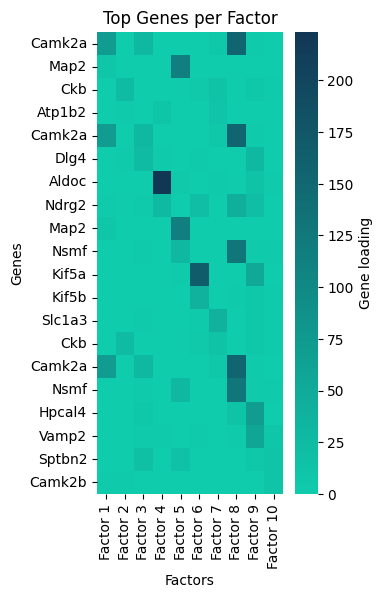

In [ ]:
troutpy.pl.rank_factor_genes_loadings_matrixplot(sdata, layer="segmentation_free_table", n_genes=2, cmap="troutpy_reversed")

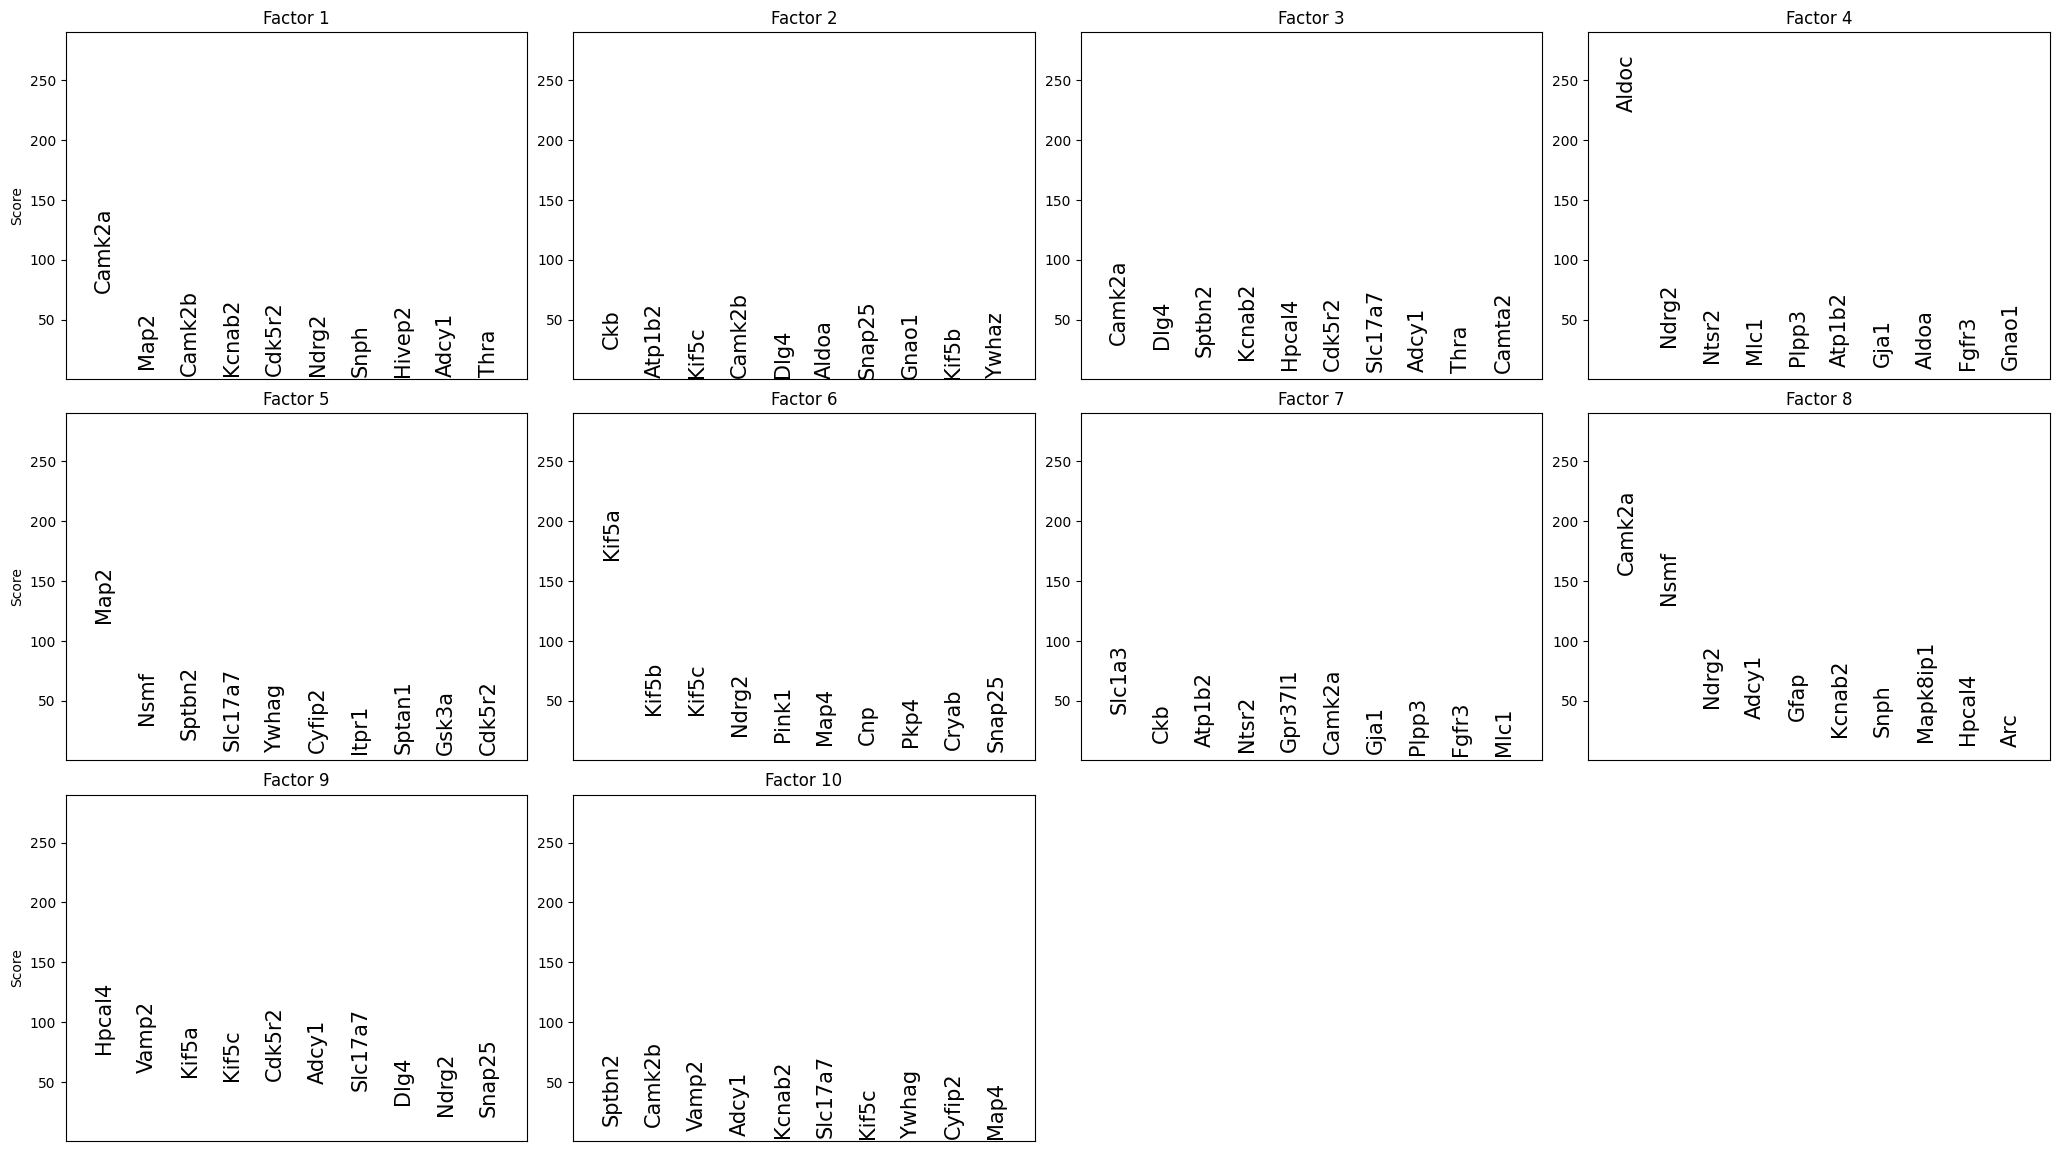

In [ ]:
troutpy.pl.rank_factor_genes_loadings(sdata, layer="segmentation_free_table", n_genes=10)

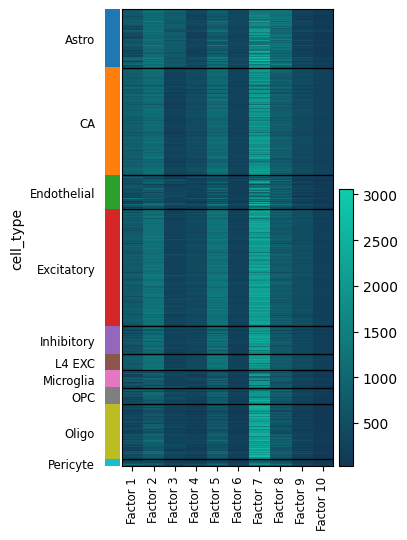

In [ ]:
troutpy.pl.factors_in_cells(sdata, layer="table", cmap="troutpy", method="heatmap")

# Next plots:
- Individual factor scores (maybe in SpatialData?)
- Joint plots exRNA+ cell factor scores

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

import troutpy as tp


def plot_factor_loadings(sdata, layer_cells="table", layer_extra="segmentation_free_table", spot_size_cells=7, spot_size_extra=12):
    """
    Plots factor loadings for each factor in a single figure with subplots, showing both intra- and extra-cellular scores.

    Args:
        sdata: spatialdata.Spatialdata
            SpatialData object containing cell and extra-cellular data.
        layer_cells: str
            Key in sdata where *cell* factor loadings are stored.
        layer_extra: str
            Key in sdata where *extra-cellular* factor loadings are stored.
        spot_size_cells: str
            Size of the marker for cells.
        spot_size_extra: str
            Size of the marker for extra-cellular spots.
    """
    cell_loadings = sc.AnnData(sdata[layer_cells].obsm["factors_cell_loadings"], obs=sdata[layer_cells].obs)
    cell_loadings.var.index = [f"Factor {i + 1}" for i in range(cell_loadings.shape[1])]
    cell_loadings.obsm["spatial"] = sdata[layer_cells].obsm["spatial"]

    extra_loadings = sc.AnnData(sdata[layer_extra].obsm["cell_loadings"], obs=sdata[layer_extra].obs)
    extra_loadings.var.index = [f"Factor {i + 1}" for i in range(extra_loadings.shape[1])]
    extra_loadings.obsm["spatial"] = sdata[layer_extra].obsm["spatial"]

    n_factors = cell_loadings.shape[1]

    cold_palette = tp.pl.get_colormap("Aquas")  # For intra-cellular factors
    warm_palette = tp.pl.get_colormap("Pinks")  # For extra-cellular factors

    n_cols = 2  # Number of columns in the grid
    n_rows = int(np.ceil(n_factors / n_cols))  # Compute number of rows needed
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 10 * n_rows))
    axes = axes.flatten()  # Flatten in case of single row

    for i in range(n_factors):
        ax = axes[i]
        factor_name = f"Factor {i + 1}"

        # Plot extra-cellular loadings (background)
        sc.pl.spatial(
            extra_loadings, color=factor_name, spot_size=spot_size_extra, show=False, ax=ax, cmap=warm_palette, marker="*", colorbar_loc=None
        )

        # Plot intra-cellular loadings (foreground with black outline)
        sc.pl.spatial(
            cell_loadings,
            color=factor_name,
            spot_size=spot_size_cells,
            show=False,
            ax=ax,
            cmap=cold_palette,
            edgecolor="black",
            linewidth=0.5,
            colorbar_loc=None,
        )

        ax.set_title(factor_name)

    # Remove empty subplots if n_factors is not a multiple of n_cols
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [ ]:
plot_factor_loadings(sdata, layer_cells="table", layer_extra="segmentation_free_table", spot_size_cells=10)

plot_factor_scores(
    sdata,
    extracellular_layer = "segmentation_free_table", cellular_layer='table',
    factors= None,  # Correct type hint for factors
    groupby= "cell type")

# Correlation intracellular vs extracellular signatures

In [ ]:
troutpy.tl.in_out_correlation(sdata, n_neighbors=30)

In [ ]:
correlations = sdata["xrna_metadata"].var
sorted_corrs = correlations.sort_values(by="in_out_spearmanR", ascending=False)

In [ ]:
import matplotlib.pyplot as plt

for gene in sorted_corrs.index[:10]:
    fig, axs = plt.subplots(1, 1, figsize=(7, 7))
    # Plot the spatial distribution for extracellular transcripts
    sc.pl.spatial(sdata["segmentation_free_table"], color=gene, cmap="YlGnBu", ax=axs, show=False, spot_size=5, vmax="p99.9")
    # Overlay the cell spatial distribution
    sc.pl.spatial(sdata["table"], color=gene, cmap="Reds", title=gene, ax=axs, show=False, spot_size=7, vmax="p99.9")
    plt.show()